In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm
import lightgbm as lgbm
import time
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import KFold

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
cat_features = [col for col in test.columns if test[col].dtype == object]
print("Total categorical features:", len(cat_features))
num_features = [col for col in test.columns if test[col].dtype != object]
num_features.remove('id')
print("Total numerical features:", len(num_features))

Total categorical features: 10
Total numerical features: 14


In [3]:
train[num_features].describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.524549,0.504943,0.459321,0.478345,0.455471,0.444115,0.524634,0.503349,0.529938,0.526899,0.455904,0.508337,0.446214,0.506649
std,0.220892,0.201549,0.220642,0.192432,0.200695,0.200089,0.204875,0.225218,0.230860,0.204025,0.204493,0.231612,0.238669,0.235269
min,-0.005600,0.059644,0.004041,0.043953,0.189216,-0.060274,-0.093505,0.158121,0.064161,0.073040,0.208703,-0.087247,0.134760,-0.055105
25%,0.332143,0.338898,0.308655,0.339896,0.279853,0.314121,0.370451,0.291289,0.316662,0.361957,0.278041,0.338747,0.214572,0.352307
50%,0.407365,0.519855,0.425801,0.410090,0.411351,0.457271,0.492208,0.433909,0.558827,0.488867,0.360736,0.441384,0.377823,0.615156
75%,0.732431,0.672809,0.541525,0.604246,0.621808,0.554835,0.654793,0.730870,0.720381,0.752765,0.639388,0.709515,0.719758,0.688150
max,0.961370,1.029773,1.014156,1.093312,0.994050,1.017689,1.052666,0.873579,1.038049,0.972091,1.036541,1.044433,1.006469,0.851746


In [4]:
train[cat_features].describe()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
count,300000,300000,300000,300000,300000,300000,300000,300000,300000,300000
unique,7,8,4,2,2,15,8,4,4,2
top,C,A,B,A,A,F,E,B,C,A
freq,121054,292643,297373,276551,281471,107281,267631,149208,183752,162678


In [5]:
def create_features(df):

    df[cat_features] = df[cat_features].apply(lambda x: [ord(c) - 65 for c in x])

    return df

train = create_features(train)
test = create_features(test)
all_cols = test.columns.tolist()
all_cols.remove('id')
print("Total number of features:", len(all_cols))

Total number of features: 24


In [6]:
num_features = [col for col in all_cols if not col.startswith('cat')]

minimum = train[num_features].min()
divison = train[num_features].max() - minimum
train[num_features] = (train[num_features] - minimum)/divison
train[num_features].describe()


,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.548258,0.459010,0.450721,0.413960,0.330820,0.467909,0.539308,0.482528,0.478265,0.504820,0.298611,0.526282,0.357292,0.619455
std,0.228437,0.207755,0.218432,0.183381,0.249362,0.185617,0.178747,0.314788,0.237050,0.226934,0.247020,0.204662,0.273794,0.259436
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.349280,0.287852,0.301563,0.282023,0.112615,0.347317,0.404788,0.186129,0.259271,0.321358,0.083758,0.376426,0.091558,0.449260
50%,0.427071,0.474381,0.417537,0.348915,0.276001,0.480113,0.511018,0.385470,0.507929,0.462518,0.183651,0.467120,0.278836,0.739108
75%,0.763241,0.632045,0.532102,0.533939,0.537492,0.570622,0.652867,0.800536,0.673815,0.756046,0.520253,0.704052,0.671094,0.819599
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
test[num_features] = (test[num_features] - minimum)/divison
test[num_features].describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.547590,0.459785,0.450532,0.413849,0.330176,0.467194,0.539317,0.483008,0.477427,0.504884,0.298444,0.526657,0.356699,0.618326
std,0.228112,0.208411,0.218631,0.183326,0.248758,0.185235,0.178541,0.314828,0.236761,0.226588,0.246837,0.204735,0.273854,0.259200
min,0.019130,0.002162,-0.003252,-0.006585,0.000985,0.003965,0.001873,-0.002642,0.006397,0.010700,0.002204,0.025898,0.001264,0.007810
25%,0.349432,0.287246,0.301611,0.282407,0.112612,0.346910,0.404815,0.186016,0.259634,0.321289,0.083648,0.377308,0.091324,0.448831
50%,0.424585,0.477403,0.417299,0.348876,0.275935,0.479758,0.511383,0.390122,0.504960,0.461460,0.183875,0.467226,0.277809,0.738811
75%,0.761517,0.633871,0.531819,0.533236,0.529575,0.569704,0.652720,0.800701,0.673283,0.755278,0.520559,0.704881,0.670707,0.818293
max,1.005188,1.002281,1.000166,0.996382,0.984416,1.003571,0.995236,1.008632,1.001087,0.988642,1.012805,0.997493,0.997139,0.993344


In [8]:
seed = np.random.randint(1, 1e5)
print("Using SEED:", seed)

params = {
    "objective": "rmse",
    "metric": "rmse",
    "boosting_type": 'gbdt',
    'device_type': 'cpu',
    'seed': seed,
    'tree_learner': 'data',
    'num_threads': 4,
    'max_bin': 512,
    'max_depth': 20,
    'num_leaves': 15,
    'early_stopping_rounds': 500,
    'lambda_l1': 1.75,
    'lambda_l2': 3.25,
    'cat_l2': 1.25,
    'learning_rate': 0.005,
    'feature_fraction': 0.25,
    "feature_fraction_seed": seed,
    'bagging_fraction': 0.75,
    'bagging_freq': 50,
    'bagging_seed': seed,
    'force_col_wise': True,
    'path_smooth': 2.5,
    'cat_smooth': 2.5,
}

Using SEED: 88530


In [9]:
def RMSE(y_true, y_pred):
    return np.sqrt(MSE(y_true, y_pred))

import warnings
warnings.filterwarnings("ignore")


lgbm_models = []
lgbm_history = []
target_cols = 'target'
X = train[all_cols]
y = train[target_cols]

kf = KFold(n_splits=5, random_state=seed, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
    print("Fold :", fold+1)
    st_time = time.time()
    evals_result = {}
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]

    lgbm_train = lgbm.Dataset(X_train, y_train)
    lgbm_valid = lgbm.Dataset(X_valid, y_valid, reference=lgbm_train)

    model_lgbm = lgbm.train(
        params=params,
        train_set=lgbm_train,
        valid_sets=[lgbm_train, lgbm_valid],
        num_boost_round=100000,
        verbose_eval=1000,
        categorical_feature=cat_features,
        evals_result=evals_result,
    )

    lgbm_y_pred = model_lgbm.predict(X_valid, num_iteration=model_lgbm.best_iteration)
    score = RMSE(y_true=y_valid, y_pred=lgbm_y_pred)
    print(f'Performance of the　LGBM prediction MSE: {score:.5}')
    lgbm_models.append((max(0, 1- score**2), model_lgbm))
    lgbm_history.append(evals_result)
    diff_time = time.time() - st_time
    print(f"Total time spent on fold: {int(diff_time/60)} min {round(diff_time%60, 4)} sec")
    print("#"*100)

Fold : 1
[LightGBM] [Info] Total Bins 7228
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 24
[LightGBM] [Info] Start training from score 7.456597
Training until validation scores don't improve for 500 rounds
[1000]	training's rmse: 0.8524	valid_1's rmse: 0.85198
[2000]	training's rmse: 0.844692	valid_1's rmse: 0.845498
[3000]	training's rmse: 0.84094	valid_1's rmse: 0.843067
[4000]	training's rmse: 0.838541	valid_1's rmse: 0.842036
[5000]	training's rmse: 0.836645	valid_1's rmse: 0.841484
[6000]	training's rmse: 0.834967	valid_1's rmse: 0.841148
[7000]	training's rmse: 0.833402	valid_1's rmse: 0.840934
[8000]	training's rmse: 0.831901	valid_1's rmse: 0.840756
[9000]	training's rmse: 0.830485	valid_1's rmse: 0.840628
[10000]	training's rmse: 0.829094	valid_1's rmse: 0.840551
[11000]	training's rmse: 0.827714	valid_1's rmse: 0.840444
[12000]	training's rmse: 0.826388	valid_1's rmse: 0.840378
Early stopping, best iteration is:
[12309]	training's

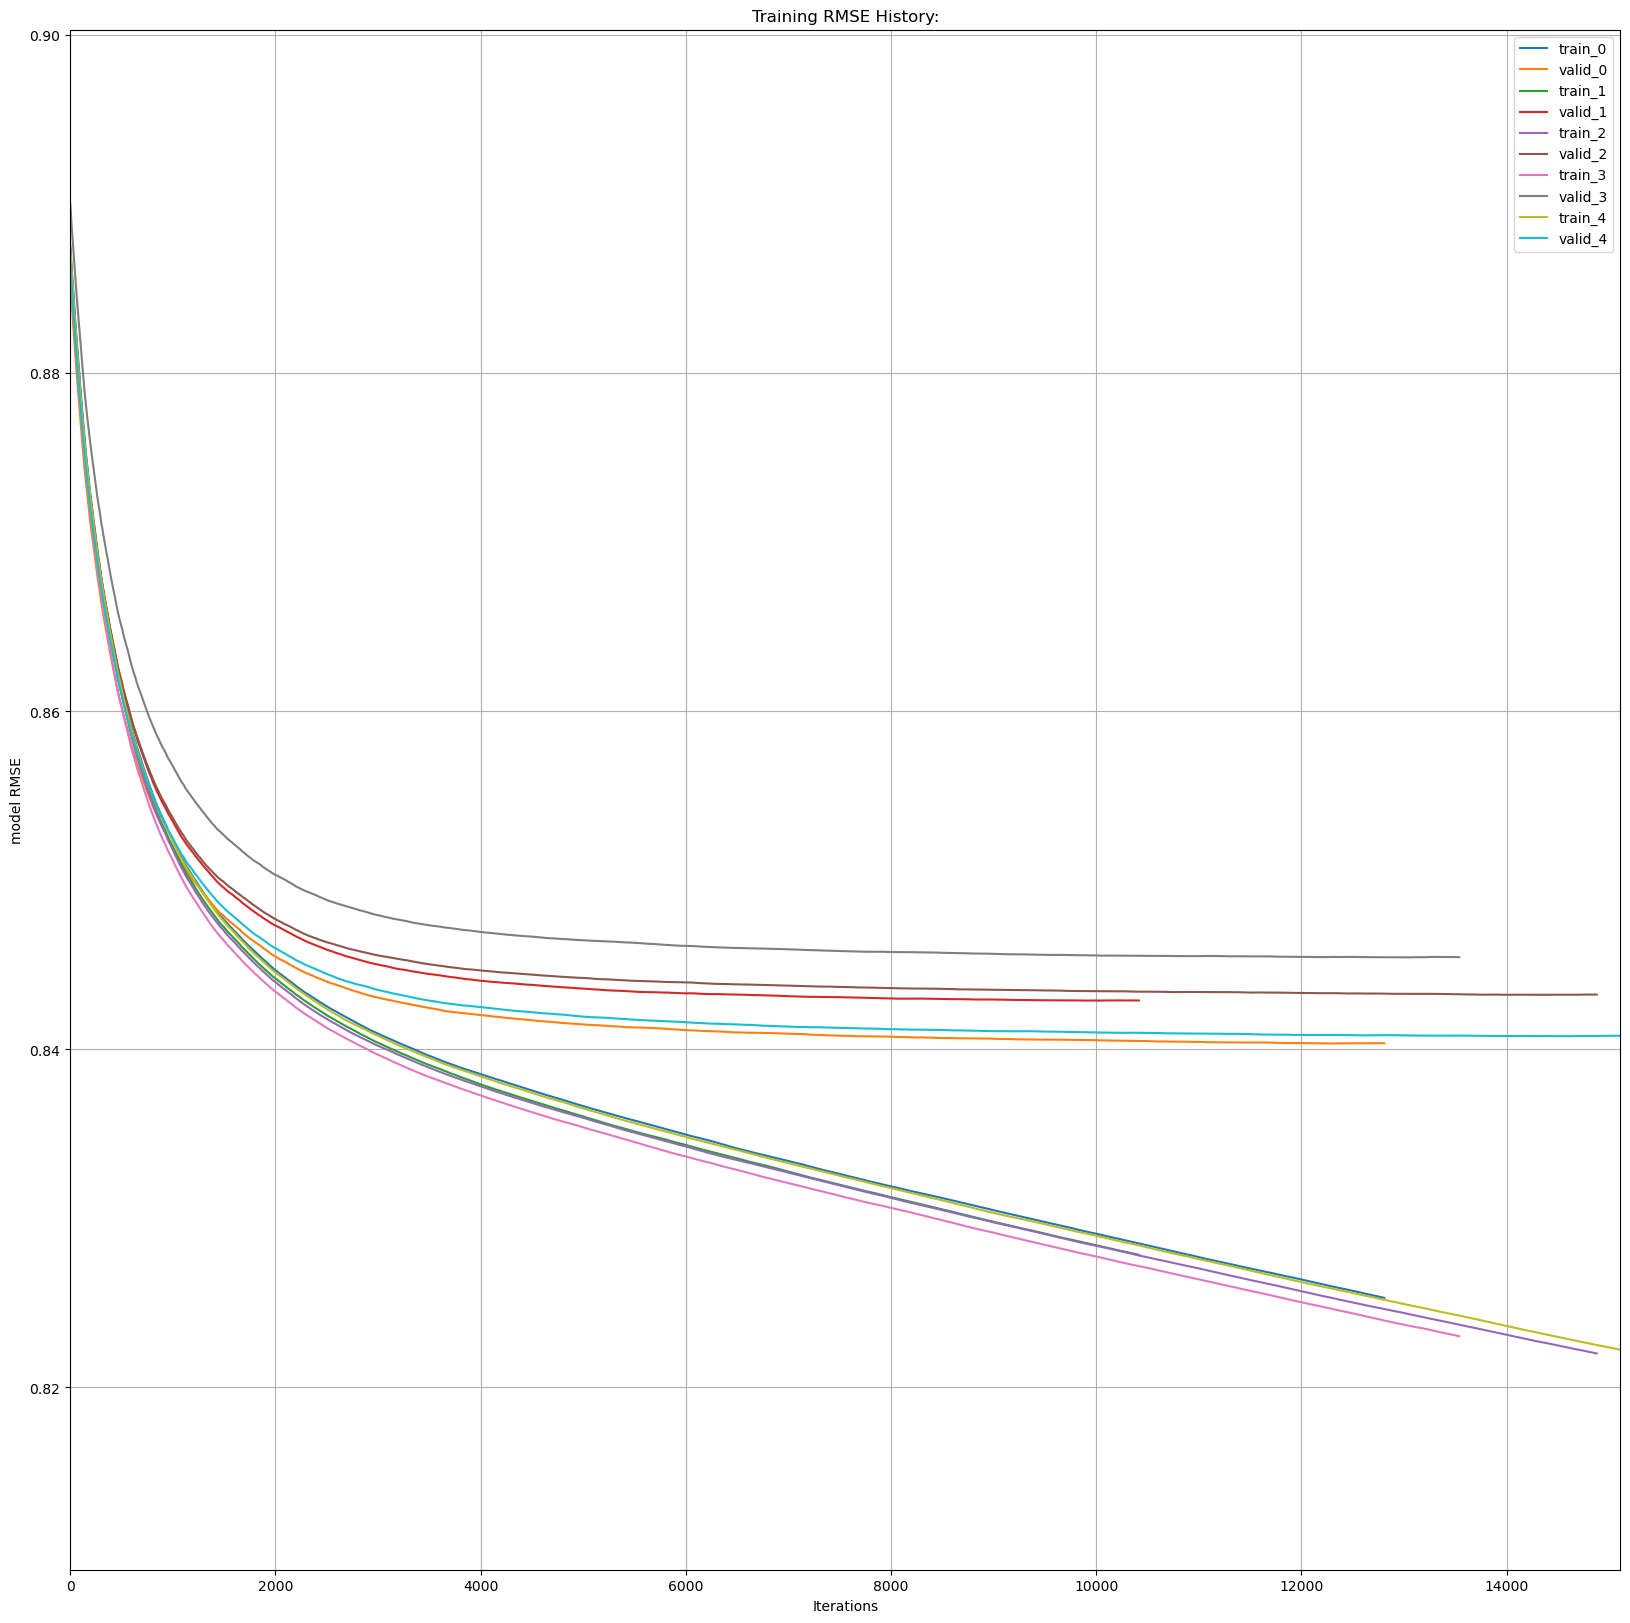

In [10]:
fig, ax = plt.subplots(figsize=(20, 20))
legends = []
for n, model in enumerate(lgbm_history):
    lgbm.plot_metric(model, metric='rmse', ax=ax, ylabel=f'model RMSE')
    legends += [f'train_{n}', f'valid_{n}']
plt.title('Training RMSE History:')
plt.legend(legends)
plt.savefig('mse_history_plot.png')

  0%|          | 0/5 [00:00<?, ?it/s]

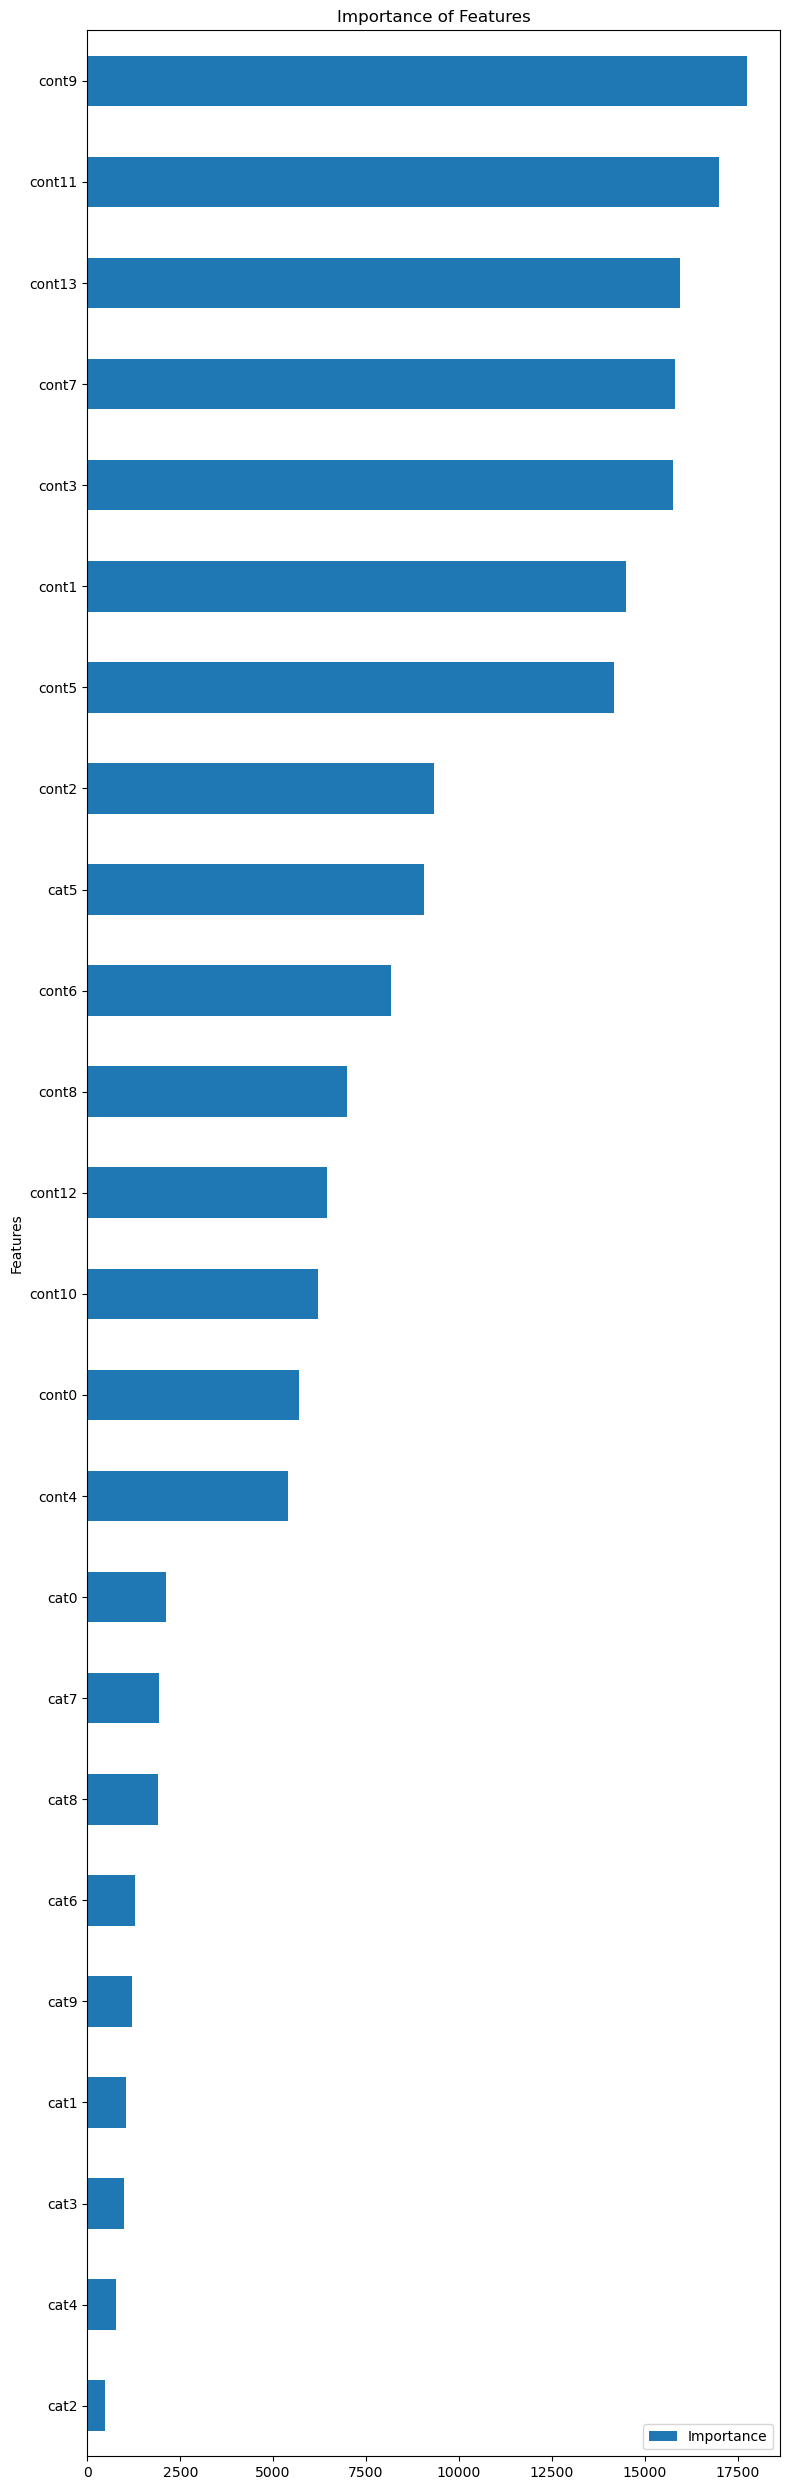

In [12]:
divisor = sum(score for score, _ in lgbm_models)

try:
    feature_importance = np.zeros((len(all_cols)))

    for score, model in tqdm(lgbm_models):
        feature_importance += model.feature_importance() * score / divisor

    importance_df = pd.DataFrame({'Features':all_cols,
                                  'Importance': feature_importance}
                                 ).sort_values('Importance')

    fig, ax = plt.subplots(figsize=(8, 25))
    importance_df.plot.barh(x='Features', y='Importance', ax=ax)
    plt.title("Importance of Features")
    plt.tight_layout()
    plt.savefig('combined_weighted_importance.png')

except Exception as e:
    print(e)

In [13]:
target = np.zeros(len(train))

for score, model in tqdm(lgbm_models):
    pred = model.predict(train[all_cols], num_iteration=model.best_iteration)
    target += pred * (score/divisor)
    print(f"Singular score: {RMSE(train[target_cols], pred):.5}")

score = RMSE(y_true = train[target_cols], y_pred = target)
print(f'Performance of the Ensemble LGBM (outliers) prediction RMSE: {score:.5}')

  0%|          | 0/5 [00:00<?, ?it/s]

Singular score: 0.82886
Singular score: 0.83142
Singular score: 0.8268
Singular score: 0.82807
Singular score: 0.82647
Performance of the Ensemble LGBM (outliers) prediction RMSE: 0.82791


In [15]:
target = np.zeros(len(test))

for score, model in tqdm(lgbm_models):
    pred = model.predict(test[all_cols], num_iteration=model.best_iteration)
    target += pred * (score/divisor)
test['target'] = target
test[['id', 'target']].to_csv('submission.csv', index=False)

sub = pd.read_csv('submission.csv')
display(sub)

  0%|          | 0/5 [00:00<?, ?it/s]

,id,target
0,0,7.657352
1,5,7.741118
2,15,7.626569
3,16,7.513195
4,17,7.264736
...,...,...
199995,499987,7.535857
199996,499990,7.290384
199997,499991,7.545215
199998,499994,7.498223
